# Predict change, instead of concentration itself

Modified from generate_data_and_fit.ipynb

In [1]:
%matplotlib inline
import warnings; warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import torch
from torch.autograd import Variable

import smog_code.kpp4py as kpp

In [2]:
from read_results import read_varnames
varnames = read_varnames("smog_code/smog_Parameters.f90")[0:12]
print(len(varnames), varnames)

12 ['HNO3', 'O', 'RH', 'RCOO2NO2', 'O3', 'HO2', 'RCOO2', 'RCHO', 'RO2', 'NO', 'NO2', 'OH']


In [3]:
df_range = pd.read_csv('smog_range.csv', index_col=0)
df_range

,min,max
HNO3,1.196871e-02,8.030713e-02
O,8.425274e-06,5.451626e-02
RH,1.850661e+00,1.977752e+00
RCOO2NO2,3.378443e-02,5.196239e-01
O3,4.626326e-02,1.750093e+00
HO2,9.376380e-07,2.617925e-01
RCOO2,4.809425e-07,2.341105e-02
RCHO,1.358315e+00,1.988463e+00
RO2,8.080372e-07,2.479889e-01
NO,5.853498e-09,1.661183e-01


In [4]:
y0_list = np.random.uniform(df_range['min'], df_range['max'], size=(5000, 12) )
y0_list.shape

(5000, 12)

In [5]:
%%time
y1_list = kpp.onestep(y0_list.T).T

CPU times: user 451 ms, sys: 3.3 ms, total: 455 ms
Wall time: 455 ms


In [6]:
scaler = StandardScaler()

scaler.fit(y0_list)
#scaler.fit(y1_list - y0_list) # 

StandardScaler(copy=True, with_mean=True, with_std=True)

In [7]:
X_train = scaler.transform(y0_list)
Y_train = scaler.transform(y1_list) - X_train # use change as output

In [8]:
Y_train.max(), Y_train.min()

(3.7782752268558246, -3.4901749138645037)

# Fit change with ANN

In [9]:
x_torch = Variable(torch.from_numpy(X_train).type(torch.FloatTensor))
y_torch = Variable(torch.from_numpy(Y_train).type(torch.FloatTensor))

In [10]:
H1, H2 = 30, 30

model = torch.nn.Sequential(
    torch.nn.Linear(12, H1),
    torch.nn.ReLU(),
    #torch.nn.BatchNorm1d(H1),
    torch.nn.Linear(H1, H2),
    torch.nn.ReLU(),
    #torch.nn.Tanh(),
    #torch.nn.BatchNorm1d(H2),
    torch.nn.Linear(H2, 12)
)

In [11]:
loss_fn = torch.nn.MSELoss()

#optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)

for t in range(3000):
    
    def closure():
        optimizer.zero_grad()
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        loss.backward()
        return loss
    optimizer.step(closure)
    
    if (t+1)%200==0:
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        print(t+1, loss.data[0])

200 0.044993311166763306
400 0.008283142931759357
600 0.00489859189838171
800 0.0037595615722239017
1000 0.002647694433107972
1200 0.001933389576151967
1400 0.0017382429214194417
1600 0.0017950240289792418
1800 0.0015417719259858131
2000 0.0011412958847358823
2200 0.001036243629641831
2400 0.001107535557821393
2600 0.0013487199321389198
2800 0.000890107941813767
3000 0.0008454913622699678


In [12]:
%%time 
y_pred = model(x_torch)
y_pred_numpy = y_pred.data.numpy()

CPU times: user 2.79 ms, sys: 517 µs, total: 3.31 ms
Wall time: 1.48 ms


In [13]:
r2_score(y_pred_numpy, Y_train)

0.99830181113354854

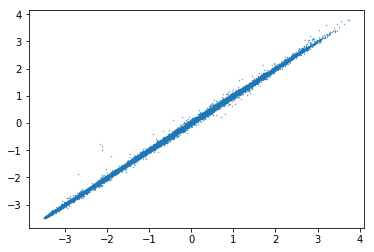

In [14]:
plt.scatter(y_pred_numpy.ravel(), Y_train.ravel(), s=0.1)

# New prediction for a single step

In [15]:
y0_test = np.random.uniform(df_range['min'], df_range['max'], size=(5000, 12) )
y1_test = kpp.onestep(y0_test.T).T

In [16]:
X_test = scaler.transform(y0_test)
Y_test = scaler.transform(y1_test) - X_test # use change!

In [17]:
X_torch_test = Variable(torch.from_numpy(X_test).type(torch.FloatTensor))
y_test_pred = model(X_torch_test).data.numpy()
y_test_pred.shape

(5000, 12)

In [18]:
r2_score(y_test_pred, Y_test)

0.99830179418079734

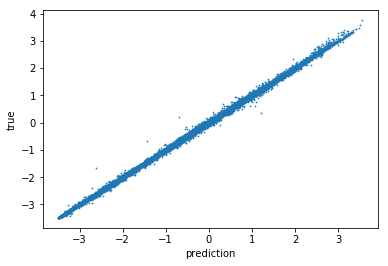

In [19]:
plt.scatter(y_test_pred, Y_test, s=0.5)
plt.xlabel('prediction')
plt.ylabel('true')

# Predict time series

## Reference solution

In [20]:
y_start = y0_test[0]
y_history_true = kpp.forward(y_start, 10).T

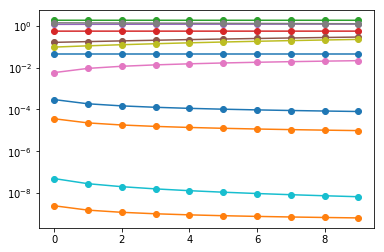

In [21]:
plt.plot(y_history_true, '-o')
plt.yscale('log')

In [22]:
y_history_true_normed  = scaler.transform(y_history_true)

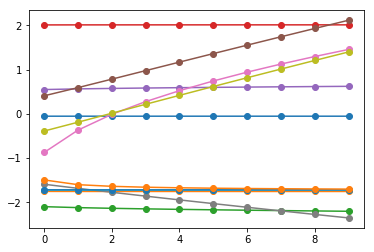

In [23]:
plt.plot(y_history_true_normed, '-o');

## NN prediction

In [24]:
y_start_normed = scaler.transform(y_start.reshape(1, -1))

In [25]:
y_history_pred = []

v_torch_temp = Variable(torch.from_numpy(y_start_normed).type(torch.FloatTensor))

for t in range(10):
    v_torch_temp = model(v_torch_temp) + v_torch_temp # change + original
    y_history_pred.append(v_torch_temp.data.numpy().ravel())
    
y_history_pred = np.array(y_history_pred)

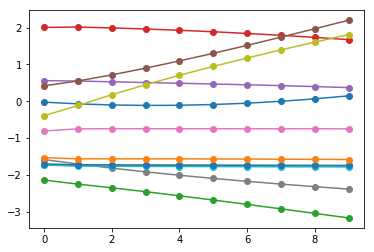

In [26]:
plt.plot(y_history_pred, '-o');

## Comparison

(-2.3558874862704644, 2.1166305289147918)

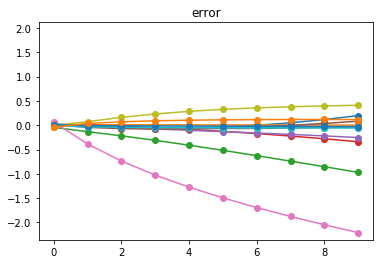

In [27]:
plt.plot(y_history_pred - y_history_true_normed, '-o')
plt.title('error')
plt.ylim(y_history_true_normed.min(), y_history_true_normed.max())

# Predict multiple time series

In [28]:
%%time
n_step = 10

y_end = y0_test.copy() # will be the final concentration
for i in range(n_step):
    y_end = kpp.onestep(y_end.T).T

y_end = scaler.transform(y_end)

CPU times: user 1.14 s, sys: 29 ms, total: 1.17 s
Wall time: 1.09 s


In [29]:
%%time
v_torch_temp = Variable(torch.from_numpy(X_test).type(torch.FloatTensor))

for t in range(n_step):
    v_torch_temp = model(v_torch_temp) + v_torch_temp
    
y_end_pred = v_torch_temp.data.numpy()

CPU times: user 35.4 ms, sys: 8 ms, total: 43.4 ms
Wall time: 22.1 ms


In [30]:
r2_score(y_end_pred.ravel(), y_end.ravel())

0.89176957220307762

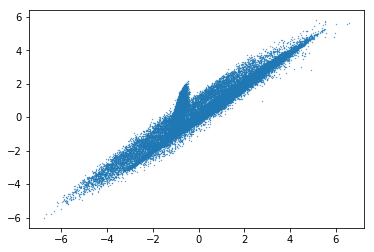

In [31]:
plt.scatter(y_end_pred.ravel(), y_end.ravel(), s=0.1)